In [240]:
import fastbook
fastbook.setup_book()

from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

In [241]:
path = untar_data(URLs.MNIST_SAMPLE)
Path.BASE_PATH = path

path.ls()

(#3) [Path('valid'),Path('labels.csv'),Path('train')]

In [242]:
(path/'train').ls()

(#2) [Path('train/7'),Path('train/3')]

In [243]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
threes

(#6131) [Path('train/3/10.png'),Path('train/3/10000.png'),Path('train/3/10011.png'),Path('train/3/10031.png'),Path('train/3/10034.png'),Path('train/3/10042.png'),Path('train/3/10052.png'),Path('train/3/1007.png'),Path('train/3/10074.png'),Path('train/3/10091.png')...]

In [244]:
im3_path = threes[1]
im3 = Image.open(im3_path)
im3

In [245]:
array(im3)[4:10,4:10]

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)

In [246]:
im3_t = tensor(im3)
df = pd.DataFrame(im3_t[4:15, 4:22])
df.style.set_properties(**{'font-size': '6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


In [247]:
seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]
len(three_tensors), len(seven_tensors)

(6131, 6265)

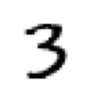

In [248]:
show_image(three_tensors[1]);

In [249]:
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255
stacked_threes.shape

torch.Size([6131, 28, 28])

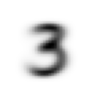

In [250]:
mean3 = stacked_threes.mean(0)
show_image(mean3);

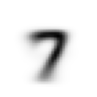

In [251]:
mean7 = stacked_sevens.mean(0)
show_image(mean7);

In [252]:
a_3 = stacked_threes[1]

dist_3_abs = (a_3 - mean3).abs().mean()
dist_3_sqr = ((a_3 - mean3)**2).mean().sqrt()
dist_3_abs, dist_3_sqr

(tensor(0.1114), tensor(0.2021))

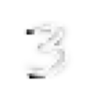

In [253]:
show_image((a_3 - mean3)**2);

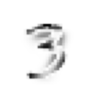

In [254]:
show_image((a_3 - mean7)**2);

In [255]:
dist_7_abs = (a_3-mean7).abs().mean()
dist_7_sqr = ((a_3-mean7)**2).mean().sqrt()
dist_7_abs, dist_7_sqr

(tensor(0.1586), tensor(0.3021))

In [256]:
F.l1_loss(a_3.float(), mean7), F.mse_loss(a_3, mean7).sqrt()

(tensor(0.1586), tensor(0.3021))

In [257]:
valid_3_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255

valid_7_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255

valid_3_tens.shape, valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

In [258]:
def minst_distance(a,b): return(a-b).abs().mean((-1, -2))
minst_distance(a_3, mean3)

tensor(0.1114)

In [259]:
valid_3_dist = minst_distance(valid_3_tens, mean3)
valid_3_dist, valid_3_dist.shape

(tensor([0.1634, 0.1145, 0.1363,  ..., 0.1105, 0.1111, 0.1640]),
 torch.Size([1010]))

In [260]:
def is_3(x): return minst_distance(x,mean3) < minst_distance(x,mean7)
is_3(a_3), is_3(a_3).float()

(tensor(True), tensor(1.))

In [261]:
is_3(valid_3_tens)

tensor([True, True, True,  ..., True, True, True])

In [262]:
accuracy_3s =      is_3(valid_3_tens).float() .mean()
accuracy_7s = (1 - is_3(valid_7_tens).float()).mean()

accuracy_3s,accuracy_7s,(accuracy_3s+accuracy_7s)/2

(tensor(0.9168), tensor(0.9854), tensor(0.9511))

In [263]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)

In [264]:
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)
train_x.shape, train_y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

In [265]:
dset = list(zip(train_x, train_y))
x,y = dset[0]
x.shape, y

(torch.Size([784]), tensor([1]))

In [266]:
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tens)+[0]*len(valid_7_tens))
valid_dset = list(zip(valid_x, valid_y))

In [267]:
def init_params(size, std=1.0): return(torch.randn(size)*std).requires_grad_()

In [268]:
weights = init_params((28*28, 1))

In [269]:
bias = init_params(1)

In [270]:
(train_x[0]*weights.T).sum() + bias

tensor([5.6385], grad_fn=<AddBackward0>)

In [271]:
def linear1(xb): return xb@weights + bias
preds = linear1(train_x)
preds

tensor([[ 5.6385],
        [ 0.2069],
        [-1.1789],
        ...,
        [12.1657],
        [ 7.8804],
        [11.0744]], grad_fn=<AddBackward0>)

In [272]:
corrects = (preds>0.0).float() == train_y
corrects

tensor([[ True],
        [ True],
        [False],
        ...,
        [False],
        [False],
        [False]])

In [273]:
corrects.float().mean().item()

0.2935624420642853

In [274]:
def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets==1, 1-predictions, predictions).mean()

In [275]:
mnist_loss(preds, train_y).mean().item()

0.6970944404602051

In [276]:
coll = range(15)
dl = DataLoader(coll, batch_size=5, shuffle=True)
list(dl)

[tensor([ 7,  4,  2,  5, 14]),
 tensor([ 8,  3,  6, 13,  1]),
 tensor([ 0, 11,  9, 12, 10])]

In [277]:
dl = DataLoader(dset, batch_size=256)
xb,yb = first(dl)
xb.shape, yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

In [278]:
valid_dl = DataLoader(valid_dset, batch_size=256)

In [279]:
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds,yb)
    loss.backward()

In [280]:
def train_epoch(model, lr, params):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad*lr
            p.grad.zero_()

In [281]:
def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds >0.5) == yb
    return correct.float().mean()

In [282]:
def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb,yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

In [283]:
validate_epoch(linear1)

0.302

In [284]:
lr = 1.
params = weights, bias
train_epoch(linear1, lr, params)
validate_epoch(linear1)

0.5067

In [285]:
for i in range(20):
    train_epoch(linear1, lr, params)
    print(validate_epoch(linear1), end=' ')

0.666 0.8237 0.8936 0.9209 0.9339 0.941 0.9468 0.9506 0.9538 0.9542 0.9561 0.9552 0.9566 0.958 0.959 0.959 0.9599 0.9599 0.9599 0.9604 

In [286]:
linear_model = nn.Linear(28*28, 1)

In [287]:
w,b = linear_model.parameters()
w.shape, b.shape

(torch.Size([1, 784]), torch.Size([1]))

In [288]:
class BasicOptim:
    def __init__(self,params, lr):
        self.params, self.lr = list(params), lr
    
    def step(self, *ars, **kwargs):
        for p in self.params: p.data -= p.grad.data * self.lr

    def zero_grad(self, *args, **kwargs):
        for p in self.params: p.grad = None

In [289]:
opt = BasicOptim(linear_model.parameters(), lr)

In [290]:
def train_epoch(model):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        opt.step()
        opt.zero_grad()

In [291]:
validate_epoch(linear_model)

0.5612

In [292]:
def train_model(model, epochs):
    for i in range(epochs):
        train_epoch(model)
        print(validate_epoch(model), end=' ')

In [293]:
train_model(linear_model, 20)

0.4932 0.7245 0.8553 0.9083 0.9258 0.9411 0.9463 0.9528 0.9543 0.9562 0.9576 0.96 0.9622 0.9627 0.9636 0.9641 0.9651 0.9656 0.9656 0.9661 

In [294]:
linear_model = nn.Linear(28*28,1)
opt = SGD(linear_model.parameters(), lr)
train_model(linear_model, 20)

0.4932 0.776 0.8497 0.9068 0.925 0.9391 0.9459 0.9523 0.9543 0.9562 0.9586 0.9604 0.9618 0.9622 0.9636 0.9646 0.9651 0.9656 0.9656 0.9661 

In [295]:
dls = DataLoaders(dl, valid_dl)

In [296]:
learn = Learner(dls, nn.Linear(28*28, 1), opt_func=SGD, loss_func=mnist_loss, metrics=batch_accuracy)

In [297]:
learn.fit(10, lr=lr)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.637110,0.503542,0.495584,00:00
1,0.540364,0.163651,0.869963,00:00
2,0.197389,0.203126,0.812853,00:00
3,0.086200,0.120720,0.898706,00:00
4,0.045245,0.090576,0.921285,00:00
5,0.029270,0.074767,0.933230,00:00
6,0.022719,0.065011,0.942775,00:00
7,0.019828,0.058557,0.950250,00:00
8,0.018379,0.054049,0.953087,00:00
9,0.017519,0.050744,0.954996,00:00


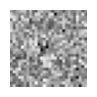

In [298]:
w_img = weights.reshape(28,28)
show_image(w_img);

In [300]:
simple_net = nn.Sequential(
    nn.Linear(28*28, 30),
    nn.ReLU(),
    nn.Linear(30,1)
    )

In [301]:
learn = Learner(dls, simple_net, opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

learn.fit(40, 0.1)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.349386,0.392439,0.518377,00:00
1,0.159364,0.247796,0.781166,00:00
2,0.086575,0.128457,0.903996,00:00
3,0.055609,0.089775,0.929688,00:00
4,0.041412,0.072594,0.944469,00:00
5,0.034276,0.063084,0.951561,00:00
6,0.030254,0.057118,0.952979,00:00
7,0.027687,0.053054,0.954451,00:00
8,0.025862,0.050100,0.957395,00:00
9,0.024462,0.047845,0.959741,00:00
